In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import r2_score

Part a

R2 score: 0.9983193277310924


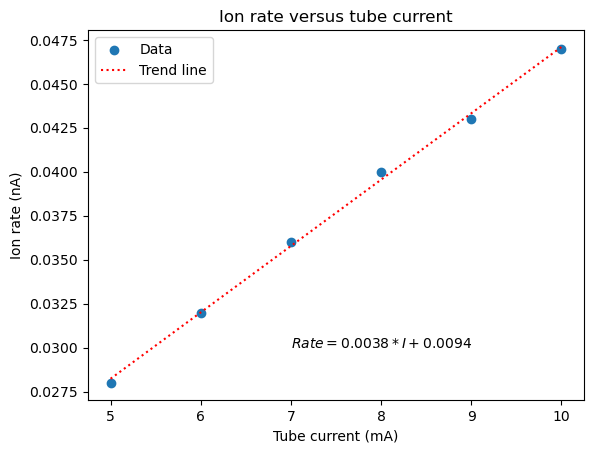

In [2]:
Rate_vs_current = pd.read_excel("Lab_data.xlsx", sheet_name='A')
Rate_vs_current["Ion rate (nA)"] = abs(Rate_vs_current["Ion rate (nA)"])

#trendline
b, a = np.polyfit(Rate_vs_current["Tube current (mA)"], Rate_vs_current["Ion rate (nA)"], deg=1)
xseq = np.linspace(5, 10, num=100)
yseq =  a + b * xseq

#calculate r2 score
pred = a + b*Rate_vs_current["Tube current (mA)"]
r2score = r2_score(Rate_vs_current["Ion rate (nA)"], pred)
print('R2 score: ' + str(r2score))

#plot data and trendline
fig = plt.figure()
ax = fig.add_subplot()
ax.text(7, 0.03, f'$Rate = {round(b,4)} * I + {round(a,4)}$')
plt.scatter(Rate_vs_current["Tube current (mA)"], Rate_vs_current["Ion rate (nA)"], label = 'Data')
plt.plot(xseq, yseq, 'r:', label='Trend line')
plt.title('Ion rate versus tube current')
plt.xlabel('Tube current (mA)')
plt.ylabel('Ion rate (nA)')
plt.legend()


Part b

Linear R2: 0.9893632009016624
Quadratic R2: 0.9999130905724313


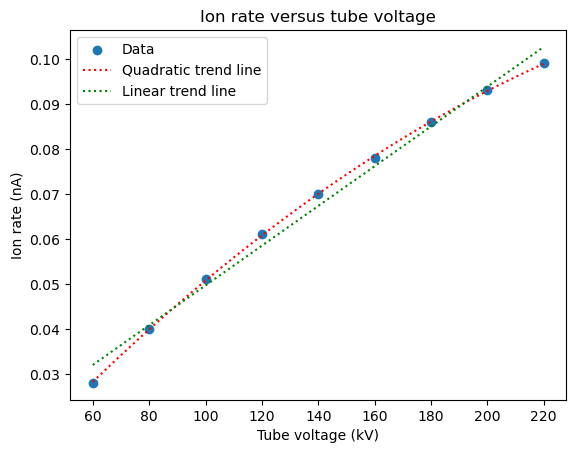

In [3]:
Rate_vs_voltage = pd.read_excel("Lab_data.xlsx", sheet_name='B')
Rate_vs_voltage["Ion rate (nA)"] = abs(Rate_vs_voltage["Ion rate (nA)"])

#linear trendline
b, a = np.polyfit(Rate_vs_voltage["Tube voltage (kV)"], Rate_vs_voltage["Ion rate (nA)"], deg=1)
xseq = np.linspace(60, 220, num=100)
yseq =  a + b * xseq

#quadratic trendline
c_q, b_q, a_q = np.polyfit(Rate_vs_voltage["Tube voltage (kV)"], Rate_vs_voltage["Ion rate (nA)"], deg=2)
xseq_q = np.linspace(60, 220, num=100)
yseq_q =  a_q + b_q * xseq + c_q * (xseq**2)

#r2 scores
pred_l = a + b * Rate_vs_voltage["Tube voltage (kV)"]
r2_l = r2_score(Rate_vs_voltage["Ion rate (nA)"], pred_l)
print("Linear R2: " + str(r2_l))

pred_q = a_q + b_q * Rate_vs_voltage["Tube voltage (kV)"] + c_q * (Rate_vs_voltage["Tube voltage (kV)"])**2
r2_q = r2_score(Rate_vs_voltage["Ion rate (nA)"], pred_q)
print("Quadratic R2: " + str(r2_q))

#plot data and trendline
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(Rate_vs_voltage["Tube voltage (kV)"], abs(Rate_vs_voltage["Ion rate (nA)"]), label = 'Data')
plt.plot(xseq_q, yseq_q, 'r:', label='Quadratic trend line')
plt.plot(xseq, yseq, 'g:', label='Linear trend line')
plt.title('Ion rate versus tube voltage')
plt.xlabel('Tube voltage (kV)')
plt.ylabel('Ion rate (nA)')
plt.legend()

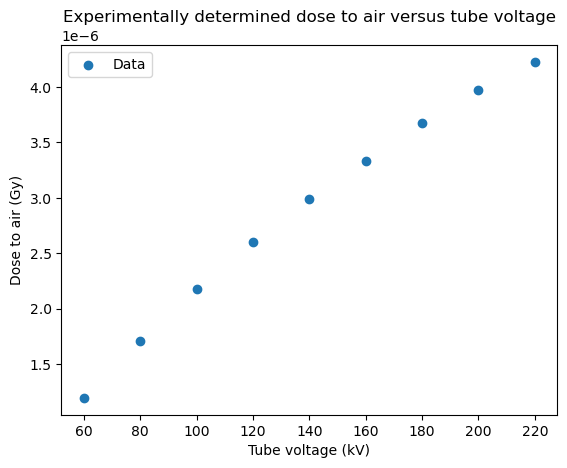

In [4]:
#Dose calculations
rho = 0.001225 #density of air in g/cm3
V = 0.65 #sensitive volume of ion chamber in cm3, obtained from https://www.iba-dosimetry.com/product/fc65-g-fc65-p-ionization-chambers
W = 33.97 #mean energy per ion pair in J/C, taken from lecture 6

Q = 1e-9*Rate_vs_voltage["Ion rate (nA)"] #exposure is the charges in C, so convert from nA

D_air_exp = (Q/(rho*V))*W

#trendline
b, a = np.polyfit(Rate_vs_voltage["Tube voltage (kV)"], D_air_exp, deg=1)
xseq = np.linspace(60, 220, num=100)
yseq =  a + b * xseq

fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(Rate_vs_voltage["Tube voltage (kV)"], D_air_exp, label = 'Data')
plt.title('Experimentally determined dose to air versus tube voltage')
plt.xlabel('Tube voltage (kV)')
plt.ylabel('Dose to air (Gy)')
plt.legend()

Use eq. 1 to calculate a theoretical voltage-dose 
curve in Python or Matlab. It may be the easiest to approximate the integral with a sum over 
a finite number of energy bins. Remember to include the effect of filtration (for each energy 
bin). Do this for the full range of voltages applied experimentally, find a way to scale the 
theoretical results and 6) plot the experimental and theoretical data together. For these tasks, 
you will need (𝜇𝑒𝑛/𝜌)𝑎𝑖𝑟 and 𝜇𝐴𝑙. 

Text(0, 0.5, 'Dose to air (Gy)')

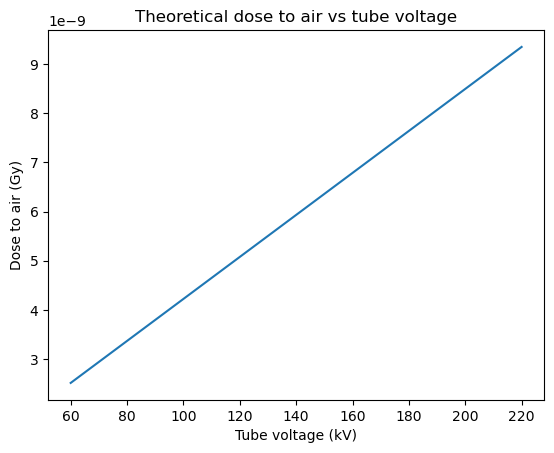

In [5]:
#Read in NIST data
Energy_coefficients = pd.read_excel("NIST data lab mass energy.xlsx")
AL_data = pd.read_excel("NIST data lab aluminium.xlsx")
Attenuation_coefficients = 2.7*AL_data["Mass att"] #convert to linear attenuations

#constants
e = 1.602e-19 #charge of electron

Energies = (1e6)*e*Energy_coefficients["Energy"]
Energy_abs_coeff_air = Energy_coefficients['Coeff']
Voltages = np.arange(60, 230, 10)
D_air = np.zeros(len(Voltages))

for i in range(len(Voltages)):
    V = Voltages[i]
    hvmax = 1000*V*e
    
    #find energies below hvmax
    locs = np.where(Energies <= hvmax)
    
    #Calculate fluence from Kramer spectrum
    K = 1 #What is K?
    Fluence = K*74*(hvmax - Energies[0:len(locs)])

    #Calculate dose to air
    D_air_all = Fluence*Energy_abs_coeff_air[0:len(locs)]
    D_air[i] = np.sum(D_air_all)
    

#plot data
plt.plot(Voltages, D_air)
plt.title("Theoretical dose to air vs tube voltage")
plt.xlabel("Tube voltage (kV)")
plt.ylabel("Dose to air (Gy)")


In [6]:
#scaling of the theoretical data to match with the experimental data
b_t, a_t = np.polyfit(Voltages, D_air, deg=1)
xseq = np.linspace(60, 220, num=100)
yseq =  a_t + b_t * xseq

scaling = b/b_t
diff = a - a_t

D_air_transformed = scaling*D_air + diff

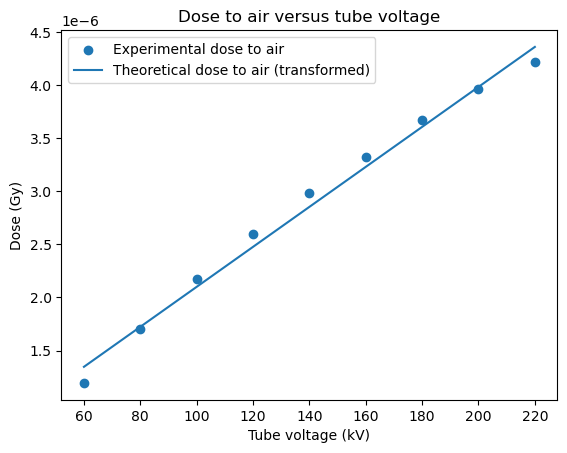

In [7]:
#plotting both in 1 figure
plt.scatter(Rate_vs_voltage["Tube voltage (kV)"], D_air_exp, label = 'Experimental dose to air')
plt.plot(Voltages, D_air_transformed, label='Theoretical dose to air (transformed)')
plt.title("Dose to air versus tube voltage")
plt.xlabel("Tube voltage (kV)")
plt.ylabel("Dose (Gy)")
plt.legend()

Part c

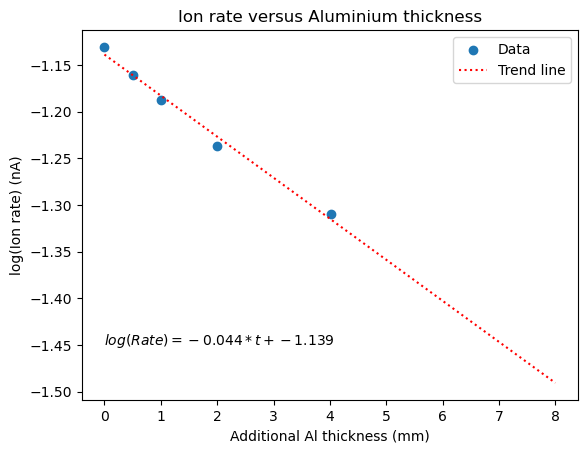

In [8]:
Rate_vs_thickness = pd.read_excel("Lab_data.xlsx", sheet_name='C')
Rate_vs_thickness["Ion rate (nA)"] = abs(Rate_vs_thickness["Ion rate (nA)"])

#trendline
b, a = np.polyfit(Rate_vs_thickness["Thickness (mm)"], np.log10(Rate_vs_thickness["Ion rate (nA)"]), deg=1)
xseq = np.linspace(0, 8, num=100)
yseq =  a + b * xseq

fig = plt.figure()
ax = fig.add_subplot()
ax.text(0, -1.45, f'$log(Rate) = {round(b,4)} * t + {round(a,4)}$')
plt.scatter(Rate_vs_thickness["Thickness (mm)"], np.log10(Rate_vs_thickness["Ion rate (nA)"]), label = 'Data')
plt.plot(xseq, yseq, 'r:', label='Trend line')
plt.title('Ion rate versus Aluminium thickness')
plt.xlabel('Additional Al thickness (mm)')
plt.ylabel('log(Ion rate) (nA)')
plt.legend()

In [9]:
HVL = (np.log10(Rate_vs_thickness["Ion rate (nA)"][0]/2) - a)/(b)
print('HVL: ' + str(HVL) + ' mm')

HVL: 6.661068927760828 mm


In [10]:
mu = (math.log(2))/(HVL/10)
mass_att = mu/2.7

print("Mass attenuation: "+ str(mass_att))

df_closest = AL_data["Energy"].iloc[(AL_data["Mass att"]-mass_att).abs().argsort()[:1]]
print("Equivalent photon energy: "+ str(df_closest.values[0]) + " MeV")

Mass attenuation: 0.3854053767785643
Equivalent photon energy: 0.05 MeV


Text(0, 0.5, 'Dose to air (Gy)')

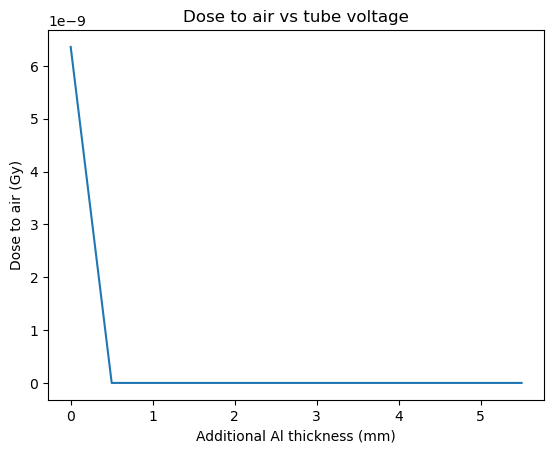

In [11]:
#Read in NIST data
Energy_coefficients = pd.read_excel("NIST data lab mass energy.xlsx")
AL_data = pd.read_excel("NIST data lab aluminium.xlsx")
Attenuation_coefficients = 2.7*AL_data["Mass att"] #convert to linear attenuations

#constants
e = 1.602e-19 #charge of electron

Energies = (1e6)*e*Energy_coefficients["Energy"]
Energy_abs_coeff_air = Energy_coefficients['Coeff']
Depths = np.arange(0, 6, 0.5)
D_air = np.zeros(len(Depths))

V = 150
hvmax = 1000*V*e
    
#find energies below hvmax
locs = np.where(Energies <= hvmax)
Energies = Energies[0:len(locs)]
Energy_abs_coeff_air = Energy_abs_coeff_air[0:len(locs)]


for i in range(len(Depths)):
    x = Depths[i]
      
    #Calculate fluence from Kramer spectrum
    K = 1 #What is K?
    filtration_factor = (math.e)**(-Attenuation_coefficients*x) #for each energy, the fluence will decrease by a factor e^-mux
    Fluence = K*74*(hvmax - Energies)*filtration_factor

    #Calculate dose to air
    D_air_all = Fluence*Energy_abs_coeff_air
    D_air[i] = np.sum(D_air_all)
    

#plot data
plt.plot(Depths, D_air)
plt.title("Dose to air vs tube voltage")
plt.xlabel("Additional Al thickness (mm)")
plt.ylabel("Dose to air (Gy)")

Part D

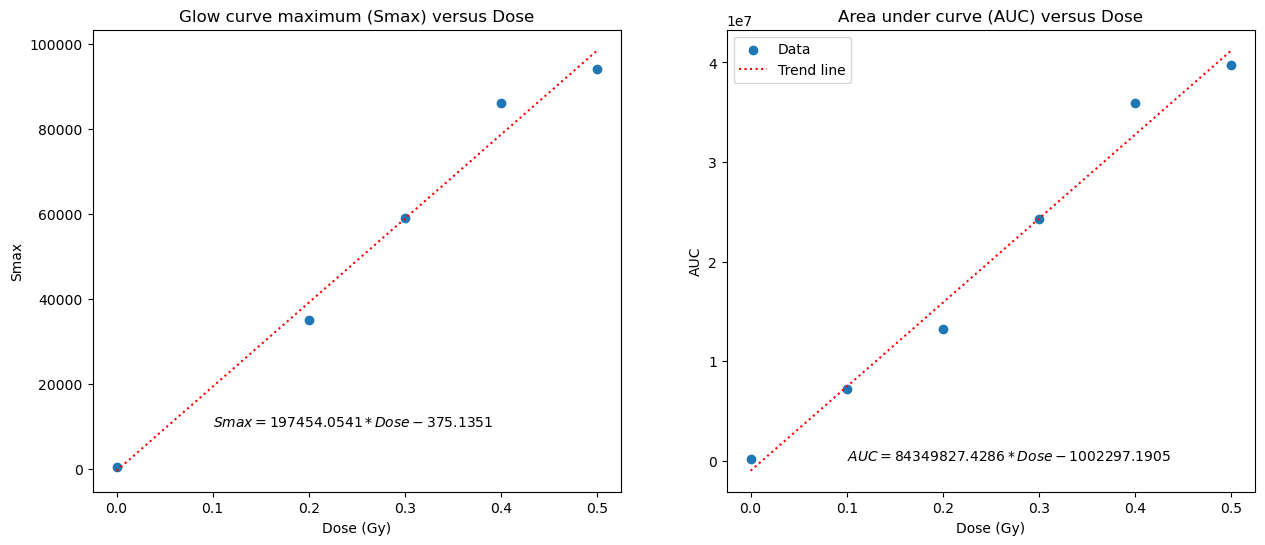

In [12]:
Dosimetry = pd.read_excel("Lab_data.xlsx", sheet_name = 'D')

#trendline Smax
a_max, b_max = np.polyfit(Dosimetry.drop(index = 1)['Doses (Gy)'], Dosimetry.drop(index = 1)['Smax'], deg=1)
xseq = np.linspace(0, 0.5, num=100)
yseq_max =  a_max * xseq + b_max

#trendline AUC
a_auc, b_auc = np.polyfit(Dosimetry['Doses (Gy)'], Dosimetry['AUC'], deg=1)
xseq = np.linspace(0, 0.5, num=100)
yseq_auc =  a_auc * xseq + b_auc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.text(0.1, 10000, f'$Smax = {round(a_max,4)} * Dose {round(b_max,4)}$')
ax1.scatter(Dosimetry.drop(index = 1)['Doses (Gy)'], Dosimetry.drop(index = 1)['Smax'], label = 'Data')
ax1.plot(xseq, yseq_max, 'r:', label='Trend line')
ax1.set_title('Glow curve maximum (Smax) versus Dose')
ax1.set_xlabel('Dose (Gy)')
ax1.set_ylabel('Smax')

ax2.text(0.1, 10000, f'$AUC = {round(a_auc,4)} * Dose {round(b_auc,4)}$')
ax2.scatter(Dosimetry['Doses (Gy)'], Dosimetry['AUC'], label = 'Data')
ax2.plot(xseq, yseq_auc, 'r:', label='Trend line')
ax2.set_title('Area under curve (AUC) versus Dose')
ax2.set_xlabel('Dose (Gy)')
ax2.set_ylabel('AUC')


plt.legend()

In [13]:
pred = a_max*Dosimetry.drop(index = 1)['Doses (Gy)'] + b_max
r2 = r2_score(Dosimetry.drop(index = 1)['Smax'], pred)
print('R2 Smax: ' + str(r2))

pred = a_auc*Dosimetry['Doses (Gy)'] + b_auc
r2 = r2_score(Dosimetry['AUC'], pred)
print('R2 AUC: ' + str(r2))

R2 Smax: 0.9844011192296684
R2 AUC: 0.9836388832081283


In [14]:
#Mystery dose Smax
Mys_max = 77000
Mys_dose_max = (Mys_max - b_max)/a_max
print('Mystery dose (max): ' + str(round(Mys_dose_max,2)) + ' Gy')

#Mystery dose AUC
Mys_AUC = 30714670
Mys_dose_auc = (Mys_AUC - b_auc)/a_auc
print('Mystery dose (auc): ' + str(round(Mys_dose_auc,2)) + ' Gy')

Mystery dose (max): 0.39 Gy
Mystery dose (auc): 0.38 Gy
